In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

Using TensorFlow backend.
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type

In [12]:
batch_size = 100
original_dim = 784   #28*28
latent_dim = 2 # 隐变量取2维只是为了方便后面画图
intermediate_dim = 256
epochs = 10


In [3]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

# 算p(Z|X)的均值和方差
z_mean = Dense(latent_dim)(h)   #Dimension=2, input=h
z_log_var = Dense(latent_dim)(h)

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size,latent_dim),mean=0.)
    return z_mean + K.exp(z_log_var / 2) * epsilon
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [5]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [7]:
def vae_loss(x,x_decoded_mean):
    xent_loss = original_dim*objectives.binary_crossentropy(x,x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss+kl_loss

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop',loss=vae_loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
(x_train, y_train_), (x_test, y_test_) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
vae.fit(x_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test,x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 101us/step - loss: 158.1295 - val_loss: 158.1554
Epoch 2/10
60000/60000 [==============================] - 6s 93us/step - loss: 157.3748 - val_loss: 157.5145
Epoch 3/10
60000/60000 [==============================] - 5s 91us/step - loss: 156.7100 - val_loss: 157.0171
Epoch 4/10
60000/60000 [==============================] - 6s 92us/step - loss: 156.1380 - val_loss: 156.6687
Epoch 5/10
60000/60000 [==============================] - 6s 107us/step - loss: 155.6703 - val_loss: 156.8167
Epoch 6/10
60000/60000 [==============================] - 6s 107us/step - loss: 155.2369 - val_loss: 155.6805
Epoch 7/10
60000/60000 [==============================] - 6s 104us/step - loss: 154.8437 - val_loss: 155.8508
Epoch 8/10
60000/60000 [==============================] - 6s 106us/step - loss: 154.4898 - val_loss: 155.6870
Epoch 9/10
60000/60000 [==============================] - 6s 108us/step -

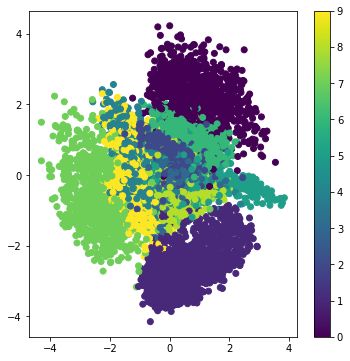

In [14]:
encoder = Model(x, z_mean)#将encoder结果可视化

x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test_)
plt.colorbar()
plt.show()

In [15]:
# 构建生成器
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

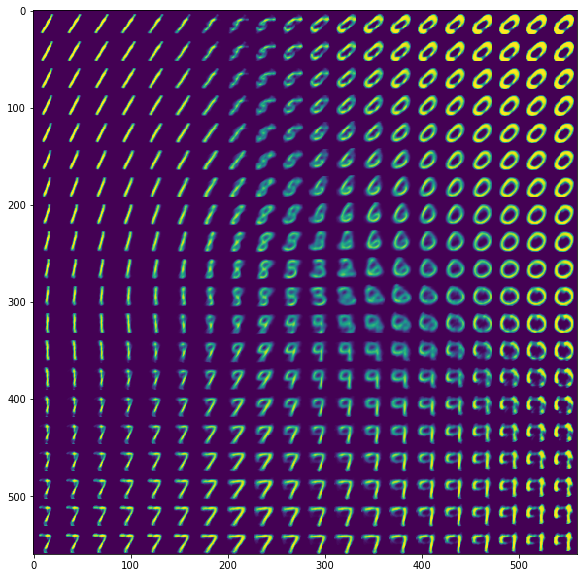

In [17]:
n = 20  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

#用正态分布的分位数来构建隐变量对
grid_x = np.linspace(-4,4,n)
grid_y = np.linspace(-4,4,n)

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-i-1) * digit_size: (n-i) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()